In [36]:
#devido aos plots no final do script devemos intalar latex na máquina
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt install cm-super


Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [37]:
%tensorflow_version 1.15.2
import tensorflow as tf   #machine learning framework
#tf.disable_v2_behavior()
print('TensorFlow version: ', tf.version)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.2`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
TensorFlow version:  <module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.7/tensorflow_core/_api/v1/version/__init__.py'>


In [38]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)
tf.set_random_seed(1234)

In [39]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([-6.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        lambda_2 = tf.exp(self.lambda_2)
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + lambda_1*u*u_x - lambda_2*u_xx
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, np.exp(lambda_2)))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = np.exp(self.sess.run(self.lambda_2))
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()
        
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda_1, self.lambda_2],
                                loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star

In [40]:
if __name__ == "__main__": 
     
    nu = 0.0075/np.pi   #nu: valor de lambda_2

    N_u = 2000  #N: número de elementos de treino
    layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
    
    data = scipy.io.loadmat('../content/un7.5.mat')
    
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = np.real(data['usol']).T   #.T: transposição da matriz de dados usol
    
    X, T = np.meshgrid(x,t)
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.flatten()[:,None]              

    # Domain bounds
    lb = X_star.min(0)
    ub = X_star.max(0)    
    
    ######################################################################
    ######################## Noiseless Data ###############################
    ######################################################################
    noise = 0.0            
             
    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]
    
    model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
    model.train(2000)
    
    u_pred, f_pred = model.predict(X_star)
            
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
        
    lambda_1_value = model.sess.run(model.lambda_1)
    lambda_2_value = model.sess.run(model.lambda_2)
    lambda_2_value = np.exp(lambda_2_value)
    
    error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
    error_lambda_2 = np.abs(lambda_2_value - nu)/nu * 100
    
    print('Error u: %e' % (error_u))    
    print('Error l1: %.5f%%' % (error_lambda_1))                             
    print('Error l2: %.5f%%' % (error_lambda_2))  
    
                               

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.425e-01, Lambda_1: 0.000, Lambda_2: 0.002477, Time: 3.31
It: 10, Loss: 2.462e-01, Lambda_1: -0.003, Lambda_2: 0.002491, Time: 0.35
It: 20, Loss: 2.204e-01, Lambda_1: -0.012, Lambda_2: 0.002515, Time: 0.28
It: 30, Loss: 2.015e-01, Lambda_1: -0.024, Lambda_2: 0.002546, Time: 0.29
It: 40, Loss: 1.874e-01, Lambda_1: -0.035, Lambda_2: 0.002576, Time: 0.31
It: 50, Loss: 1.655e-01, Lambda_1: -0.042, Lambda_2: 0.002598, Time: 0.30
It: 60, Loss: 1.392e-01, Lambda_1: -0.043, Lambda_2: 0.002594, Time: 0.28
It: 70, Loss: 1.123e-01, Lambda_1: -0.039, Lambda_2: 0.002559, Time: 0.29
It: 80, Loss: 9.072e-02, Lambda_1: -0.027, Lambda_2: 0.002510, Time: 0.29
It: 90, Loss: 7.592e-02, Lambda_1: -0.009, Lambda_2: 0.002459, Time: 0.28
It: 100, Loss: 6.560e-02, Lambda_1: 0.012, Lambda_2: 0.002406, Time: 0.29
It: 110, Loss: 5.694e-02, Lambda_1: 0.033, Lambda_2: 0.002355, Time: 0.30
It: 120, Loss: 4.911e-

In [41]:
######################################################################
########################### Noisy Data ###############################
######################################################################
noise = 0.01        
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
        
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(2000)
    
u_pred, f_pred = model.predict(X_star)
        
lambda_1_value_noisy = model.sess.run(model.lambda_1)
lambda_2_value_noisy = model.sess.run(model.lambda_2)
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)
            
error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0)*100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu)/nu * 100
    
print('Error lambda_1: %f%%' % (error_lambda_1_noisy))
print('Error lambda_2: %f%%' % (error_lambda_2_noisy))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.436e-01, Lambda_1: 0.000, Lambda_2: 0.002479, Time: 2.69
It: 10, Loss: 2.312e-01, Lambda_1: -0.007, Lambda_2: 0.002495, Time: 0.28
It: 20, Loss: 2.272e-01, Lambda_1: -0.017, Lambda_2: 0.002520, Time: 0.26
It: 30, Loss: 2.211e-01, Lambda_1: -0.028, Lambda_2: 0.002549, Time: 0.27
It: 40, Loss: 2.130e-01, Lambda_1: -0.038, Lambda_2: 0.002578, Time: 0.27
It: 50, Loss: 2.029e-01, Lambda_1: -0.048, Lambda_2: 0.002610, Time: 0.27
It: 60, Loss: 1.819e-01, Lambda_1: -0.056, Lambda_2: 0.002638, Time: 0.27
It: 70, Loss: 1.373e-01, Lambda_1: -0.058, Lambda_2: 0.002636, Time: 0.26
It: 80, Loss: 8.802e-02, Lambda_1: -0.049, Lambda_2: 0.002592, Time: 0.28
It: 90, Loss: 6.599e-02, Lambda_1: -0.030, Lambda_2: 0.002541, Time: 0.27
It: 100, Loss: 5.694e-02, Lambda_1: -0.008, Lambda_2: 0.002486, Time: 0.27
It: 110, Loss: 4.884e-02, Lambda_1: 0.013, Lambda_2: 0.002435, Time: 0.27
It: 120, Loss: 4.363e

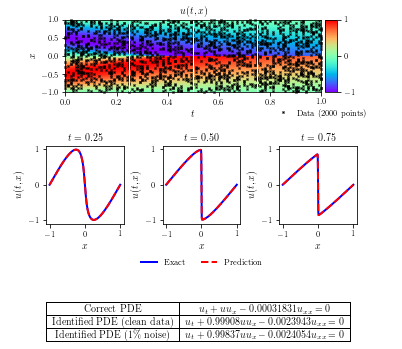

In [42]:
 
######################################################################
############################# Plotting ###############################
######################################################################    
    
fig, ax = newfig(1.0, 1.4)
ax.axis('off')
    
####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
    
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
    
ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 2, clip_on = False)
    
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)
    
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(loc='upper center', bbox_to_anchor=(1.0, -0.125), ncol=5, frameon=False)
ax.set_title('$u(t,x)$', fontsize = 10)
    
####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)
    
ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
    
ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    
ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)
    
####### Row 3: Identified PDE ##################    
gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=1.0-2.0/3.0, bottom=0, left=0.0, right=1.0, wspace=0.0)
    
ax = plt.subplot(gs2[:, :])
ax.axis('off')
s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t + u u_x - 0.00031831 u_{xx} = 0$ \\  \hline Identified PDE (clean data) & '
s2 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value)
s3 = r'Identified PDE (1\% noise) & '
s4 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy)
s5 = r'\end{tabular}$'
s = s1+s2+s3+s4+s5
ax.text(0.1,0.1,s)
        
savefig('./Burgers_identification')  
    
